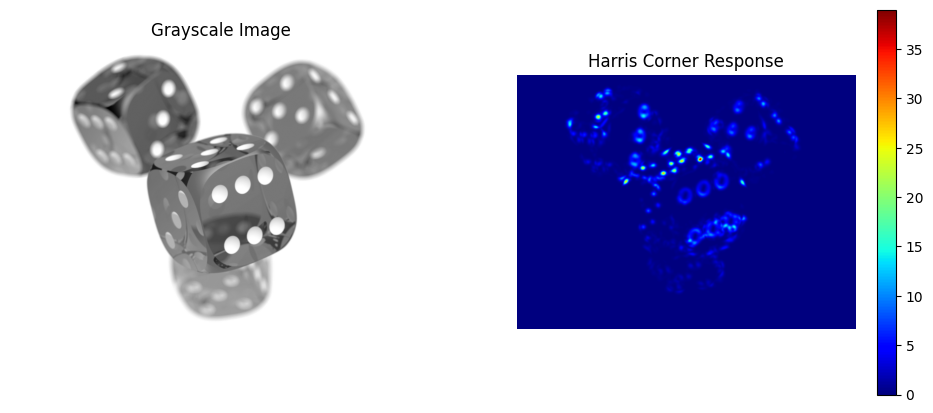

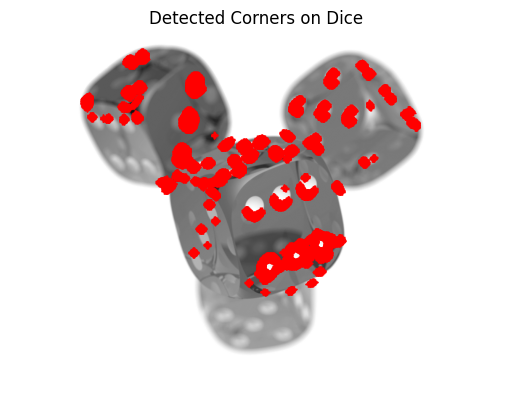

In [2]:
from PIL import Image
from numpy import *
from pylab import *
from scipy.ndimage import gaussian_filter

# ✅ Step 1: Load transparent PNG and convert to grayscale safely
img_rgba = Image.open('/content/dice_transparency_demonstration_1.png').convert('RGBA')

# Convert to white background to handle transparency
background = Image.new("RGB", img_rgba.size, (255, 255, 255))
background.paste(img_rgba, mask=img_rgba.split()[3])  # 3 = Alpha channel
im_gray = background.convert('L')
im = array(im_gray)

# ✅ Step 2: Define Harris Corner Function
def compute_harris_response(im, sigma=3):
    imx = zeros(im.shape)
    gaussian_filter(im, sigma=(sigma, sigma), order=(0, 1), output=imx)

    imy = zeros(im.shape)
    gaussian_filter(im, sigma=(sigma, sigma), order=(1, 0), output=imy)

    Wxx = gaussian_filter(imx**2, sigma)
    Wxy = gaussian_filter(imx*imy, sigma)
    Wyy = gaussian_filter(imy**2, sigma)

    Wdet = Wxx * Wyy - Wxy**2
    Wtr = Wxx + Wyy

    return Wdet / (Wtr + 1e-12)  # Avoid division by zero

# ✅ Step 3: Compute Harris Response
harris_response = compute_harris_response(im)

# ✅ Step 4: Visualize Original & Harris Response
figure(figsize=(12, 5))

subplot(1, 2, 1)
imshow(im, cmap='gray')
title("Grayscale Image")
axis('off')

subplot(1, 2, 2)
imshow(harris_response, cmap='jet')
title("Harris Corner Response")
colorbar()
axis('off')

show()

# ✅ Step 5: Plot Detected Corners
corner_threshold = 0.1 * harris_response.max()
corner_coords = array(where(harris_response > corner_threshold)).T

imshow(im, cmap='gray')
plot(corner_coords[:, 1], corner_coords[:, 0], 'r+', markersize=5)
title("Detected Corners on Dice")
axis('off')
show()


In [3]:
from PIL import Image
from numpy import *
from pylab import *
from scipy.ndimage import gaussian_filter, maximum_filter

# === Harris Response Function ===
def compute_harris_response(im, sigma=3):
    imx = zeros(im.shape)
    gaussian_filter(im, (sigma, sigma), order=(0, 1), output=imx)

    imy = zeros(im.shape)
    gaussian_filter(im, (sigma, sigma), order=(1, 0), output=imy)

    Wxx = gaussian_filter(imx**2, sigma)
    Wxy = gaussian_filter(imx*imy, sigma)
    Wyy = gaussian_filter(imy**2, sigma)

    Wdet = Wxx * Wyy - Wxy**2
    Wtr = Wxx + Wyy

    return Wdet / (Wtr + 1e-12)

# === Harris Point Extraction with Non-Maximum Suppression ===
def get_harris_points(harrisim, min_dist=10, threshold=0.1):
    # Find top corner candidates above a threshold
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1

    # Get coordinates of candidates
    coords = array(harrisim_t.nonzero()).T
    candidate_values = [harrisim[c[0], c[1]] for c in coords]

    # Sort candidates by corner strength
    index = argsort(candidate_values)[::-1]

    # Non-maximum suppression
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist, min_dist:-min_dist] = 1

    filtered_coords = []
    for i in index:
        r, c = coords[i]
        if allowed_locations[r, c] == 1:
            filtered_coords.append((r, c))
            allowed_locations[r - min_dist:r + min_dist + 1, c - min_dist:c + min_dist + 1] = 0

    return filtered_coords

# === Plotting Harris Points ===
def plot_harris_points(image, filtered_coords):
    figure(figsize=(8, 6))
    gray()
    imshow(image)
    plot([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], '*', color='red')
    axis('off')
    title('Harris Corners')
    show()


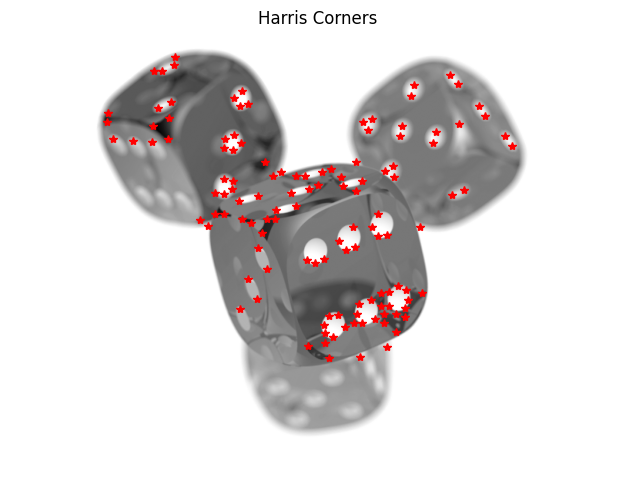

In [4]:
# === Load Your Local Image ===
im_rgba = Image.open('/content/dice_transparency_demonstration_1.png').convert('RGBA')
bg = Image.new("RGB", im_rgba.size, (255, 255, 255))
bg.paste(im_rgba, mask=im_rgba.split()[3])
im_gray = bg.convert('L')
im = array(im_gray)

# === Run Harris Pipeline ===
harrisim = compute_harris_response(im)
filtered_coords = get_harris_points(harrisim, min_dist=10, threshold=0.1)
plot_harris_points(im, filtered_coords)


In [5]:
def get_descriptors(image, filtered_coords, wid=5):
    """ Extracts (2*wid+1)x(2*wid+1) patches around each keypoint. """
    desc = []
    for coords in filtered_coords:
        patch = image[coords[0]-wid:coords[0]+wid+1, coords[1]-wid:coords[1]+wid+1].flatten()
        desc.append(patch)
    return desc

def match(desc1, desc2, threshold=0.5):
    """ Matches descriptors using Normalized Cross-Correlation. """
    n = len(desc1[0])
    d = -ones((len(desc1), len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - mean(desc1[i])) / std(desc1[i])
            d2 = (desc2[j] - mean(desc2[j])) / std(desc2[j])
            ncc_value = sum(d1 * d2) / (n - 1)
            if ncc_value > threshold:
                d[i, j] = ncc_value
    ndx = argsort(-d, axis=1)
    matchscores = ndx[:, 0]
    return matchscores


In [6]:
from scipy.ndimage import affine_transform
# Load and convert original dice image
img_path = '/content/dice_transparency_demonstration_1.png'
im_rgba = Image.open(img_path).convert('RGBA')
bg = Image.new("RGB", im_rgba.size, (255, 255, 255))
bg.paste(im_rgba, mask=im_rgba.split()[3])
im1 = array(bg.convert('L'))

# Create a second image (slightly rotated)
im2 = affine_transform(im1, matrix=[[1, 0.05], [-0.05, 1]], offset=(0, 0))

# Get Harris corners
harris1 = compute_harris_response(im1)
harris2 = compute_harris_response(im2)

coords1 = get_harris_points(harris1, min_dist=10, threshold=0.1)
coords2 = get_harris_points(harris2, min_dist=10, threshold=0.1)

desc1 = get_descriptors(im1, coords1, wid=5)
desc2 = get_descriptors(im2, coords2, wid=5)

matches = match(desc1, desc2, threshold=0.9)


<ipython-input-5-2801632388>:16: RuntimeWarning: invalid value encountered in divide
  d2 = (desc2[j] - mean(desc2[j])) / std(desc2[j])


In [7]:
def append_images(im1, im2):
    """ Combine two images side-by-side. """
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]
    if rows1 < rows2:
        im1 = vstack((im1, zeros((rows2 - rows1, im1.shape[1]))))
    elif rows2 < rows1:
        im2 = vstack((im2, zeros((rows1 - rows2, im2.shape[1]))))
    return hstack((im1, im2))

def plot_matches(im1, im2, locs1, locs2, matchscores):
    im3 = append_images(im1, im2)
    imshow(im3, cmap='gray')
    cols1 = im1.shape[1]
    for i, m in enumerate(matchscores):
        if m < len(locs2):
            plot([locs1[i][1], locs2[m][1] + cols1],
                 [locs1[i][0], locs2[m][0]], 'c')
    axis('off')
    show()


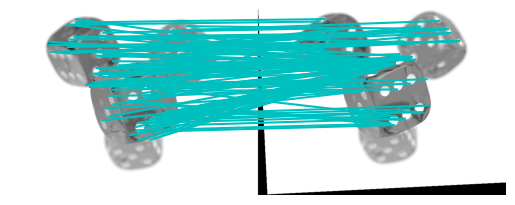

In [8]:
plot_matches(im1, im2, coords1, coords2, matches)


In [9]:
def match_twosided(desc1, desc2, threshold=0.5):
    """ Two-sided symmetric version of match(). Keeps only mutual best matches. """

    matches_12 = match(desc1, desc2, threshold)
    matches_21 = match(desc2, desc1, threshold)

    # Indices where a match was found
    ndx_12 = where(matches_12 >= 0)[0]

    # Remove non-symmetric matches
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1

    return matches_12


In [10]:
def appendimages(im1, im2):
    """ Return a new image that appends the two images side-by-side. """
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]

    # Pad shorter image with zeros
    if rows1 < rows2:
        im1 = concatenate((im1, zeros((rows2 - rows1, im1.shape[1]))), axis=0)
    elif rows1 > rows2:
        im2 = concatenate((im2, zeros((rows1 - rows2, im2.shape[1]))), axis=0)

    return concatenate((im1, im2), axis=1)

def plot_matches(im1, im2, locs1, locs2, matchscores, show_below=True):
    """ Show a figure with lines joining the accepted matches.
        im1, im2: input images (arrays)
        locs1, locs2: keypoint locations [(y,x), ...]
        matchscores: list of indices from locs1 to locs2
    """
    im3 = appendimages(im1, im2)

    if show_below:
        im3 = vstack((im3, im3))

    figure(figsize=(12, 6))
    gray()
    imshow(im3)

    cols1 = im1.shape[1]

    for i, m in enumerate(matchscores):
        if m > 0:
            plot([locs1[i][1], locs2[m][1] + cols1],
                 [locs1[i][0], locs2[m][0]], 'c')

    axis('off')
    show()


<ipython-input-5-2801632388>:16: RuntimeWarning: invalid value encountered in divide
  d2 = (desc2[j] - mean(desc2[j])) / std(desc2[j])
<ipython-input-5-2801632388>:15: RuntimeWarning: invalid value encountered in divide
  d1 = (desc1[i] - mean(desc1[i])) / std(desc1[i])


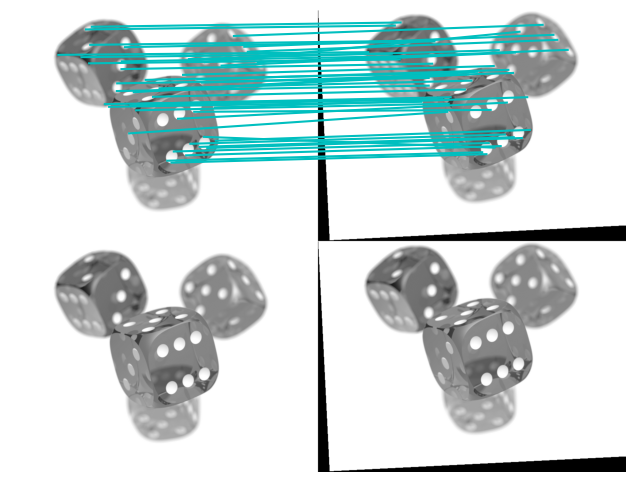

Total matches found: 44


In [11]:
matches = match_twosided(desc1, desc2, threshold=0.9)
plot_matches(im1, im2, coords1, coords2, matches)

print(f"Total matches found: {sum(matches > 0)}")


Starting matching...


<ipython-input-5-2801632388>:16: RuntimeWarning: invalid value encountered in divide
  d2 = (desc2[j] - mean(desc2[j])) / std(desc2[j])
<ipython-input-5-2801632388>:15: RuntimeWarning: invalid value encountered in divide
  d1 = (desc1[i] - mean(desc1[i])) / std(desc1[i])


<Figure size 640x480 with 0 Axes>

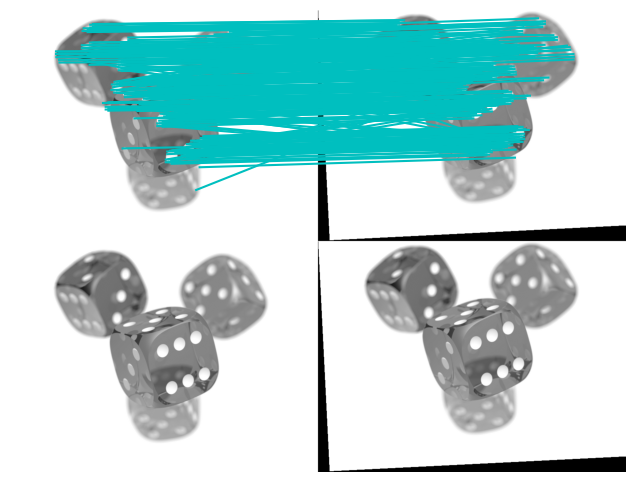

In [12]:
wid = 5

# Harris corners and descriptors for image 1
harrisim1 = compute_harris_response(im1, 5)
filtered_coords1 = get_harris_points(harrisim1, wid + 1)
d1 = get_descriptors(im1, filtered_coords1, wid)

# Harris corners and descriptors for image 2
harrisim2 = compute_harris_response(im2, 5)
filtered_coords2 = get_harris_points(harrisim2, wid + 1)
d2 = get_descriptors(im2, filtered_coords2, wid)

print('Starting matching...')

# Match descriptors
matches = match_twosided(d1, d2)

# Plot matches
figure()
gray()
plot_matches(im1, im2, filtered_coords1, filtered_coords2, matches)
show()


In [13]:
print(f"Total matches found: {sum(matches > 0)}")


Total matches found: 341


In [14]:
import os
from PIL import Image

def process_image(imagename, resultname, params="--edge-thresh 10 --peak-thresh 5"):
    """Process an image and save the SIFT features to a result file."""

    if imagename[-3:].lower() != 'pgm':
        # Convert to grayscale .pgm for SIFT binary
        im = Image.open(imagename).convert('L')
        im.save('tmp.pgm')
        imagename = 'tmp.pgm'

    cmmd = f"sift {imagename} --output={resultname} {params}"
    os.system(cmmd)

    print(f'Processed {imagename} to {resultname}')


In [15]:
from numpy import loadtxt, savetxt, hstack

def read_features_from_file(filename):
    """Read feature properties and return location and descriptors."""
    data = loadtxt(filename)
    return data[:, :4], data[:, 4:]

def write_features_to_file(filename, locs, desc):
    """Save features and descriptors to a file."""
    savetxt(filename, hstack((locs, desc)))


In [16]:
!pip install opencv-contrib-python --quiet


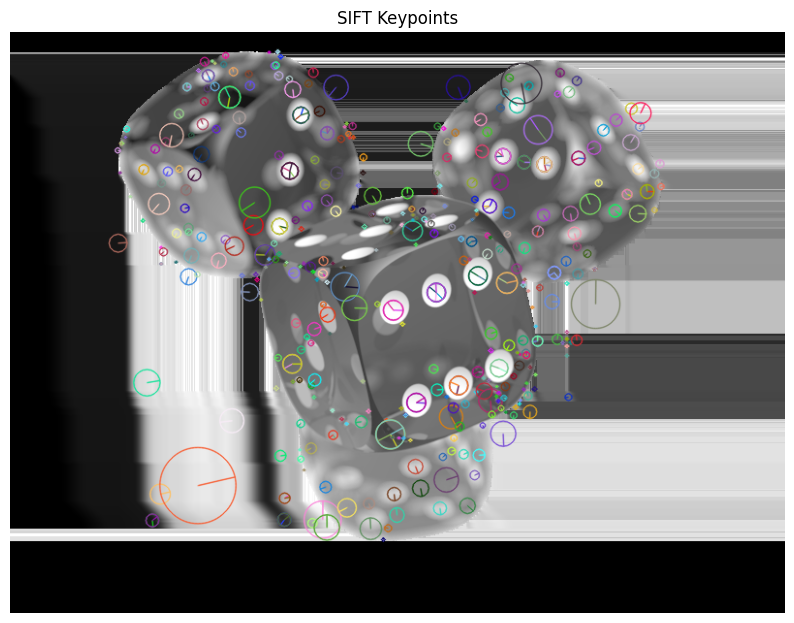

Number of keypoints detected: 438
First descriptor vector (128 dimensions):
 [  7.   1.   0.   0.   0.   0.   0.   0. 154.  32.   1.   0.   0.   0.
   1.  17.  86.  28.   7.  14.  25.  68.  16.  21.   0.   0.   9.  12.
  11.  36.  60.  31.   3.   1.   0.   0.   0.   0.   0.   0. 154.  98.
   0.   0.   0.   0.   0.   3. 154. 102.   1.   1.   6.  23.  37.  53.
   3.   0.   0.   0.   1.  24. 138.  29.   0.   0.   0.   0.   0.   0.
   0.   0. 154.  22.   0.   0.   0.   0.   0.   5. 154.  43.   0.   0.
   2.  11.  20.  88.  17.   2.   0.   0.  13.  49.  55.  18.   0.   0.
   0.   0.   0.   0.   0.   0.  71.  30.   0.   0.   0.   0.   0.   0.
 154. 154.   0.   0.   4.   4.   0.   2.  49.  24.   1.   1.  48.  28.
   1.   1.]


In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load image
image_path = '/content/dice_transparency_demonstration_1.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Create SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(gray, None)

# Draw keypoints on the image
img_with_keypoints = cv2.drawKeypoints(gray, keypoints, None,
                                       flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show the image with keypoints
plt.figure(figsize=(10, 8))
plt.imshow(img_with_keypoints, cmap='gray')
plt.title('SIFT Keypoints')
plt.axis('off')
plt.show()

# Optional: print first few descriptors
print("Number of keypoints detected:", len(keypoints))
print("First descriptor vector (128 dimensions):\n", descriptors[0])


In [18]:
import os
import json
import requests
from urllib.parse import urlparse

# Fallback if simplejson is preferred
try:
    import simplejson as json
except ImportError:
    import json




In [19]:
import urllib.request

# Download 3 random images
for i in range(10):
    url = f"https://picsum.photos/400/300?random={i}"
    filename = f"picsum_{i}.jpg"
    urllib.request.urlretrieve(url, filename)
    print(f"Downloaded {filename}")


Downloaded picsum_0.jpg
Downloaded picsum_1.jpg
Downloaded picsum_2.jpg
Downloaded picsum_3.jpg
Downloaded picsum_4.jpg
Downloaded picsum_5.jpg
Downloaded picsum_6.jpg
Downloaded picsum_7.jpg
Downloaded picsum_8.jpg
Downloaded picsum_9.jpg


In [20]:
sift_code = """
from numpy import *
from PIL import Image
import os

def read_features_from_file(filename):
    f = loadtxt(filename)
    return f[:, :4], f[:, 4:]

def write_features_to_file(filename, locs, desc):
    savetxt(filename, hstack((locs, desc)))

def match(desc1, desc2, threshold=0.5):
    n = desc1.shape[0]
    d = -ones(n, 'int')
    for i in range(n):
        dotprods = dot(desc1[i, :], desc2.T)
        dotprods = 1.0 - dotprods  # distance = 1 - cosine similarity
        if len(dotprods) < 2: continue
        indx = argsort(dotprods)
        if dotprods[indx[0]] < threshold * dotprods[indx[1]]:
            d[i] = indx[0]
    return d

def match_twosided(desc1, desc2, threshold=0.5):
    matches_12 = match(desc1, desc2, threshold)
    matches_21 = match(desc2, desc1, threshold)
    ndx_12 = where(matches_12 >= 0)[0]
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
    return matches_12
"""

# Write to sift.py
with open("sift.py", "w") as f:
    f.write(sift_code)

# Now import it
import sift


In [21]:
import os
import numpy as np
import sift  # Make sure you have your custom sift.py with the right functions



if not os.path.exists("images"):
    os.makedirs("images")
    print("Created folder 'images'")


# Step 1: Get list of images and corresponding .sift feature files
image_dir = './images'  # Change this to your actual folder path
imlist = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
imlist.sort()  # Optional: sort for consistency

featlist = [os.path.splitext(im)[0] + '.sift' for im in imlist]
featlist = [os.path.join(image_dir, f) for f in featlist]  # Add full path

# Step 2: Initialize score matrix
nbr_images = len(imlist)
matchscores = np.zeros((nbr_images, nbr_images))

# Step 3: Compute matches
for i in range(nbr_images):
    for j in range(i, nbr_images):  # Only upper triangle (including diagonal)
        print('Comparing', imlist[i], 'with', imlist[j])
        l1, d1 = sift.read_features_from_file(featlist[i])
        l2, d2 = sift.read_features_from_file(featlist[j])

        matches = sift.match_twosided(d1, d2)
        nbr_matches = np.sum(matches > 0)
        print('Number of matches =', nbr_matches)

        matchscores[i, j] = nbr_matches

# Step 4: Mirror upper triangle to lower triangle
for i in range(nbr_images):
    for j in range(i + 1, nbr_images):
        matchscores[j, i] = matchscores[i, j]

# Step 5: (Optional) Print final match score matrix
print("\nMatch Score Matrix (Number of matches between images):")
print(matchscores)


Created folder 'images'

Match Score Matrix (Number of matches between images):
[]


In [22]:
!pip install pydot
!apt-get install graphviz  -y # only for Linux or Colab


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


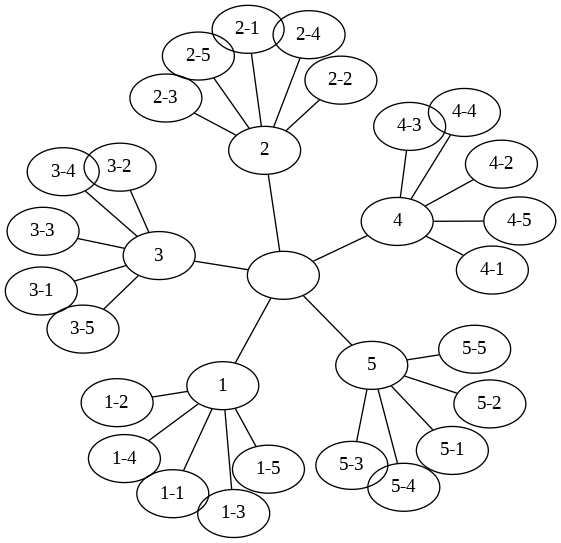

In [23]:
# Install required packages (if not already done)
!pip install pydot
!apt-get install graphviz -y

# Import necessary libraries
import pydot
from IPython.display import Image, display  # <-- this is what was missing!

# Create a new graph
g = pydot.Dot(graph_type='graph')

# Add root node (invisible)
g.add_node(pydot.Node(str(0), fontcolor='transparent'))

# Add first-level and second-level nodes
for i in range(5):
    g.add_node(pydot.Node(str(i + 1)))
    g.add_edge(pydot.Edge(str(0), str(i + 1)))

    for j in range(5):
        child_name = f"{j + 1}-{i + 1}"
        g.add_node(pydot.Node(child_name))
        g.add_edge(pydot.Edge(child_name, str(j + 1)))

# Save the graph image
g.write_png('graph_output.png', prog='neato')

# Display the graph
display(Image('graph_output.png'))


In [27]:
from PIL import Image
import pydot
import os

# Input dice image
input_image = 'dice_transparency_demonstration_1.png'
output_image = 'dice_graph.png'  # Output graph image
thumbnail_name = 'dice_thumb.png'

# Create thumbnail of the dice image
im = Image.open(input_image)
im.thumbnail((100, 100))
im.save(thumbnail_name)

# Create graph
graph = pydot.Dot(graph_type='graph')

# Add only one node (since we have only one image)
graph.add_node(pydot.Node("dice",
                          fontcolor='transparent',
                          shape='rectangle',
                          image=thumbnail_name))

# Save graph image
graph.write_png(output_image)

print("Graph image saved as:", output_image)


Graph image saved as: dice_graph.png
